# Regression Models: Performance Comparison Across Datasets

This notebook compares three different approaches to modeling conditional probability distributions using Gaussian Mixture Models. We'll test them on various datasets to see which works best for different types of problems.

## The Three Models

**1. ConditionalGMMRegressor**
- **What it does**: Fits a joint Gaussian mixture to all variables [X, y] together, then uses mathematical conditioning to get p(y|X)
- **Pros**: Simple, fast, interpretable
- **Cons**: May not be optimal for conditional prediction since it optimizes the joint distribution

**2. MixtureOfExpertsRegressor** 
- **What it does**: Uses a "gating network" to decide which Gaussian expert should handle each input, where each expert has a linear relationship between X and y
- **Pros**: Can capture complex, non-linear conditional relationships
- **Cons**: More complex, requires more iterations to converge

**3. DiscriminativeConditionalGMMRegressor**
- **What it does**: Directly optimizes the conditional likelihood p(y|X) using a specialized training algorithm
- **Pros**: Often achieves the best conditional prediction performance
- **Cons**: More computationally intensive, requires careful regularization

## Datasets

We'll test on 6 diverse datasets to see how each model handles different types of problems:

**Classification-style problems** (predicting features from other features + labels):
- **Iris**: 150 flowers, predict sepal size from petal size and species
- **Wine**: 178 wines, predict chemical properties from other measurements and wine type  
- **Breast Cancer**: 569 samples, predict cell features from other measurements and diagnosis
- **Digits**: 1,797 handwritten digits, predict digit appearance from digit labels

**Regression problems** (predicting continuous targets):
- **California Housing**: 20,640 houses, predict house price from location and demographics
- **Diabetes**: 442 patients, predict diabetes progression from health measurements


In [1]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # must be before pyplot import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import (
    load_iris, load_wine, load_breast_cancer, load_digits,
    fetch_california_housing, load_diabetes
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from cgmm import ConditionalGMMRegressor, MixtureOfExpertsRegressor, DiscriminativeConditionalGMMRegressor

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Configure datasets for testing
# Each dataset defines: which features are targets vs conditioning variables, and number of mixture components

datasets = {
    'iris': {
        'loader': load_iris,
        'type': 'classification',
        'target_cols': [0, 1],  # sepal length, width
        'conditioning_cols': [2, 3],  # petal length, width + species labels
        'n_components': 5,
        'description': 'Predict sepal size from petal size and flower species',
        'details': 'Classic dataset: 150 iris flowers, 4 measurements each. We predict sepal dimensions (length, width) from petal dimensions and species type (setosa, versicolor, virginica).'
    },
    'wine': {
        'loader': load_wine,
        'type': 'classification', 
        'target_cols': [0, 1, 2],  # first 3 chemical features
        'conditioning_cols': list(range(3, 13)),  # remaining features + wine class
        'n_components': 5,
        'description': 'Predict wine chemistry from other measurements and wine type',
        'details': 'Wine quality dataset: 178 wines from 3 different cultivars, 13 chemical measurements each. We predict the first 3 chemical properties from the other 10 measurements plus wine class.'
    },
    'breast_cancer': {
        'loader': load_breast_cancer,
        'type': 'classification',
        'target_cols': [0, 1, 2],  # first 3 features
        'conditioning_cols': list(range(3, 30)),  # remaining features + diagnosis
        'n_components': 5,
        'description': 'Predict cell features from other measurements and diagnosis',
        'details': 'Medical dataset: 569 breast cancer samples, 30 features from cell nuclei images. We predict the first 3 features from the other 27 measurements plus diagnosis (malignant/benign).'
    },
    'digits': {
        'loader': load_digits,
        'type': 'classification',
        'target_cols': list(range(8)),  # 8 PCA components as targets
        'conditioning_cols': [],  # digit labels only
        'n_components': 7,
        'use_pca': True,
        'pca_components': 8,
        'description': 'Predict digit appearance from digit labels',
        'details': 'Handwritten digits: 1,797 8x8 pixel images of digits 0-9. We use PCA to reduce 64 pixels to 8 components, then predict these from the digit labels. This tests how well models can learn visual patterns from categorical information.'
    },
    'california_housing': {
        'loader': fetch_california_housing,
        'type': 'regression',
        'target_cols': [0],  # median house value
        'conditioning_cols': list(range(1, 8)),  # other features
        'n_components': 5,
        'description': 'Predict house price from location and demographics',
        'details': 'Real estate dataset: 20,640 California housing districts, 8 features including location, demographics, and housing characteristics. We predict median house value from the other 7 features.'
    },
    'diabetes': {
        'loader': load_diabetes,
        'type': 'regression',
        'target_cols': [0],  # disease progression
        'conditioning_cols': list(range(1, 10)),  # other features
        'n_components': 5,
        'description': 'Predict diabetes progression from health measurements',
        'details': 'Medical dataset: 442 diabetes patients, 10 baseline measurements (age, sex, BMI, blood pressure, etc.). We predict disease progression (continuous target) from the other 9 health measurements.'
    }
}

print("Dataset configurations:")
for name, config in datasets.items():
    print(f"\n{name.upper()}:")
    print(f"  Task: {config['description']}")
    print(f"  Details: {config['details']}")
    print(f"  Setup: {len(config['target_cols'])} targets, {len(config['conditioning_cols'])} conditioning vars, {config['n_components']} components")


Dataset configurations:

IRIS:
  Task: Predict sepal size from petal size and flower species
  Details: Classic dataset: 150 iris flowers, 4 measurements each. We predict sepal dimensions (length, width) from petal dimensions and species type (setosa, versicolor, virginica).
  Setup: 2 targets, 2 conditioning vars, 5 components

WINE:
  Task: Predict wine chemistry from other measurements and wine type
  Details: Wine quality dataset: 178 wines from 3 different cultivars, 13 chemical measurements each. We predict the first 3 chemical properties from the other 10 measurements plus wine class.
  Setup: 3 targets, 10 conditioning vars, 5 components

BREAST_CANCER:
  Task: Predict cell features from other measurements and diagnosis
  Details: Medical dataset: 569 breast cancer samples, 30 features from cell nuclei images. We predict the first 3 features from the other 27 measurements plus diagnosis (malignant/benign).
  Setup: 3 targets, 27 conditioning vars, 5 components

DIGITS:
  Task: 

In [3]:
# Helper functions

def prepare_dataset(dataset_name, config):
    """Load and prepare a dataset for testing."""
    loader = config['loader']
    data = loader()
    
    X = data.data
    y = data.target
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if config['type'] == 'classification':
        # Special case for digits: use digit labels as conditioning, PCA-reduced pixels as targets
        if dataset_name == 'digits':
            # Apply PCA reduction to make the problem more manageable
            pca = PCA(n_components=config.get('pca_components', 8))
            X_pca = pca.fit_transform(X_scaled)
            
            # Use PCA-reduced pixel values as targets
            y_target = X_pca  # (n_samples, pca_components)
            
            # Use one-hot encoded digit labels as conditioning variables
            encoder = OneHotEncoder(sparse_output=False)
            X_conditioning = encoder.fit_transform(y.reshape(-1, 1))  # (n_samples, 10)
            
            return y_target, X_conditioning, data.target_names if hasattr(data, 'target_names') else None
        
        else:
            # For other classification datasets: use some features as targets, others as conditioning
            # Add one-hot encoded class labels to conditioning variables
            encoder = OneHotEncoder(sparse_output=False)
            y_encoded = encoder.fit_transform(y.reshape(-1, 1))
            
            y_target = X_scaled[:, config['target_cols']]
            X_conditioning = np.hstack([
                X_scaled[:, config['conditioning_cols']],
                y_encoded
            ])
            
            return y_target, X_conditioning, data.target_names if hasattr(data, 'target_names') else None
    
    else:  # regression
        # For regression: use target as y, features as X
        y_target = y.reshape(-1, 1)
        X_conditioning = X_scaled[:, config['conditioning_cols']]
        
        return y_target, X_conditioning, None

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a model and return key performance metrics."""
    try:
        # Log-likelihood (higher is better)
        log_likelihood = model.score(X_test, y_test)
        
        # Mean predictions
        y_pred = model.predict(X_test)
        
        # Standard regression metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Normalized MSE for better comparison across datasets
        target_variance = np.var(y_test)
        normalized_mse = mse / target_variance if target_variance > 0 else mse
        
        # Training info
        converged = getattr(model, 'converged_', 'N/A')
        n_iter = getattr(model, 'n_iter_', 'N/A')
        
        return {
            'model': model_name,
            'log_likelihood': log_likelihood,
            'mse': mse,
            'normalized_mse': normalized_mse,
            'r2': r2,
            'converged': converged,
            'n_iter': n_iter,
            'n_components': model.n_components
        }
    except Exception as e:
        return {
            'model': model_name,
            'log_likelihood': np.nan,
            'mse': np.nan,
            'normalized_mse': np.nan,
            'r2': np.nan,
            'converged': False,
            'n_iter': 'N/A',
            'n_components': model.n_components,
            'error': str(e)
        }


In [4]:
# Compare all three models on each dataset
results = []

for dataset_name, config in datasets.items():

    # Prepare dataset
    y_target, X_conditioning, class_names = prepare_dataset(dataset_name, config)
        
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_conditioning, y_target, test_size=0.3, random_state=42
    )
    
    # Test all three models
    models_to_test = [
        ("ConditionalGMMRegressor", ConditionalGMMRegressor(
            n_components=config['n_components'],
            covariance_type="full",
            random_state=42
        )),
        ("MixtureOfExpertsRegressor", MixtureOfExpertsRegressor(
            n_components=config['n_components'],
            covariance_type="full",
            mean_function="affine",
            random_state=42
        )),
        ("DiscriminativeConditionalGMMRegressor", DiscriminativeConditionalGMMRegressor(
            n_components=config['n_components'],
            covariance_type="full",
            reg_covar=1e-2,
            random_state=42
        ))
    ]
    
    dataset_results = []
    for model_name, model in models_to_test:
        model.fit(X_train, y_train)
        result = evaluate_model(model, X_test, y_test, model_name)
        result['dataset'] = dataset_name
        results.append(result)
        dataset_results.append(result)

    # Find best model for this dataset
    best_result = max(dataset_results, key=lambda x: x['log_likelihood'])
        




In [5]:
# Analyze results
df_results = pd.DataFrame(results)

print("RESULTS SUMMARY")
print("="*60)

# Create a clean comparison table
comparison_data = []
for dataset in df_results['dataset'].unique():
    dataset_results = df_results[df_results['dataset'] == dataset]
    
    for _, row in dataset_results.iterrows():
        comparison_data.append({
            'Dataset': dataset,
            'Model': row['model'].replace('Regressor', ''),
            'Log-Likelihood': f"{row['log_likelihood']:.3f}",
            'R²': f"{row['r2']:.3f}",
            'Iterations': row['n_iter']
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Count wins by model
print(f"\nMODEL PERFORMANCE RANKINGS:")
print("="*40)

wins = {'ConditionalGMMRegressor': 0, 'MixtureOfExpertsRegressor': 0, 'DiscriminativeConditionalGMMRegressor': 0}

for dataset in df_results['dataset'].unique():
    dataset_results = df_results[df_results['dataset'] == dataset]
    best_model = dataset_results.loc[dataset_results['log_likelihood'].idxmax(), 'model']
    wins[best_model] += 1
    print(f"{dataset:15} → {best_model.replace('Regressor', '')}")

print(f"\nTotal wins:")
for model, count in wins.items():
    print(f"  {model.replace('Regressor', '')}: {count}/{len(df_results['dataset'].unique())}")


RESULTS SUMMARY
           Dataset                        Model Log-Likelihood    R²  Iterations
              iris               ConditionalGMM         -1.915 0.582          11
              iris             MixtureOfExperts         -3.881 0.424          38
              iris DiscriminativeConditionalGMM         -1.786 0.604           6
              wine               ConditionalGMM         -5.387 0.282           2
              wine             MixtureOfExperts        -10.842 0.393          11
              wine DiscriminativeConditionalGMM         -3.524 0.431           6
     breast_cancer               ConditionalGMM          1.021 0.951          21
     breast_cancer             MixtureOfExperts         -3.047 0.865          25
     breast_cancer DiscriminativeConditionalGMM          1.212 0.962          17
            digits               ConditionalGMM        -11.637 0.434          30
            digits             MixtureOfExperts        -11.321 0.390          45
            

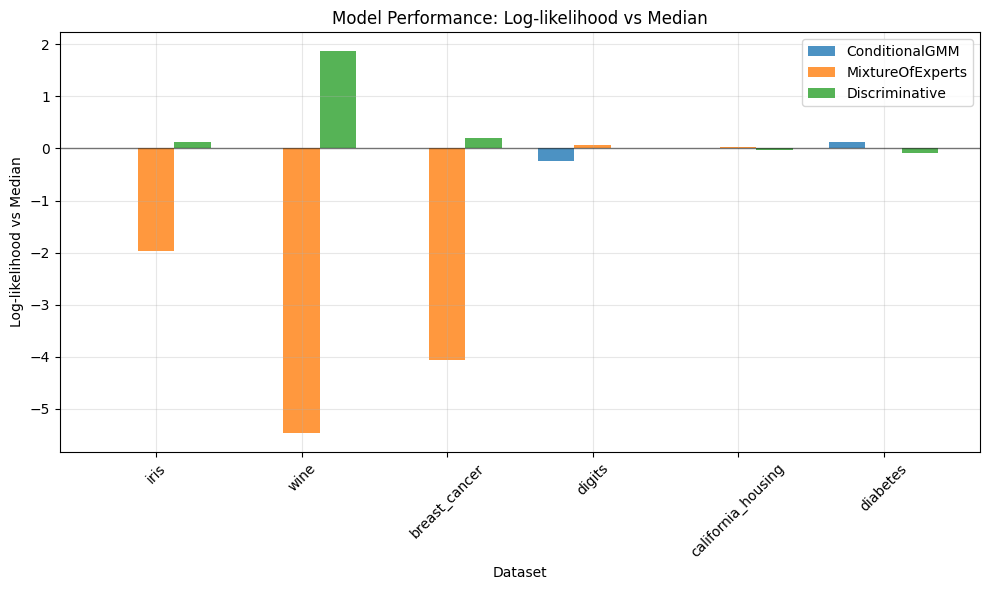

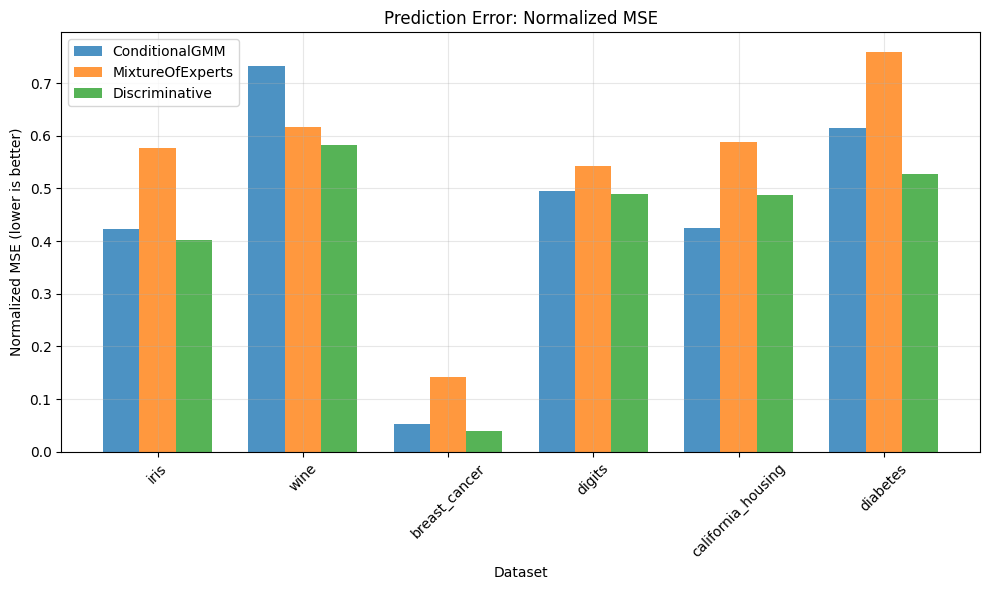

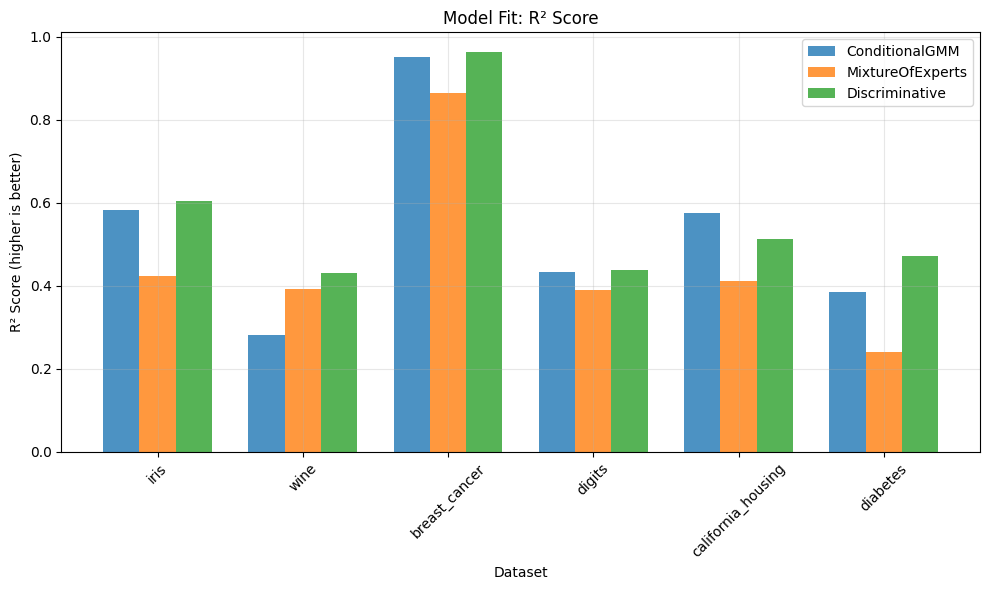

In [6]:
# Visualize the results
datasets_list = df_results['dataset'].unique()
x = np.arange(len(datasets_list))
width = 0.25

# Extract data for all models
cgmm_ll = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'ConditionalGMMRegressor')]['log_likelihood'].iloc[0] for d in datasets_list]
moe_ll = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'MixtureOfExpertsRegressor')]['log_likelihood'].iloc[0] for d in datasets_list]
disc_ll = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'DiscriminativeConditionalGMMRegressor')]['log_likelihood'].iloc[0] for d in datasets_list]

cgmm_mse = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'ConditionalGMMRegressor')]['normalized_mse'].iloc[0] for d in datasets_list]
moe_mse = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'MixtureOfExpertsRegressor')]['normalized_mse'].iloc[0] for d in datasets_list]
disc_mse = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'DiscriminativeConditionalGMMRegressor')]['normalized_mse'].iloc[0] for d in datasets_list]

cgmm_r2 = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'ConditionalGMMRegressor')]['r2'].iloc[0] for d in datasets_list]
moe_r2 = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'MixtureOfExpertsRegressor')]['r2'].iloc[0] for d in datasets_list]
disc_r2 = [df_results[(df_results['dataset'] == d) & (df_results['model'] == 'DiscriminativeConditionalGMMRegressor')]['r2'].iloc[0] for d in datasets_list]

# Plot 1: Log-likelihood vs Median
fig, ax = plt.subplots(figsize=(10, 6))
for i, dataset in enumerate(datasets_list):
    median_ll = np.median([cgmm_ll[i], moe_ll[i], disc_ll[i]])
    cgmm_diff = cgmm_ll[i] - median_ll
    moe_diff = moe_ll[i] - median_ll
    disc_diff = disc_ll[i] - median_ll
    
    ax.bar(i - width, cgmm_diff, width, label='ConditionalGMM' if i == 0 else "", color='C0', alpha=0.8)
    ax.bar(i, moe_diff, width, label='MixtureOfExperts' if i == 0 else "", color='C1', alpha=0.8)
    ax.bar(i + width, disc_diff, width, label='Discriminative' if i == 0 else "", color='C2', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax.set_xlabel('Dataset')
ax.set_ylabel('Log-likelihood vs Median')
ax.set_title('Model Performance: Log-likelihood vs Median')
ax.set_xticks(x)
ax.set_xticklabels(datasets_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Normalized MSE
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, cgmm_mse, width, label='ConditionalGMM', color='C0', alpha=0.8)
ax.bar(x, moe_mse, width, label='MixtureOfExperts', color='C1', alpha=0.8)
ax.bar(x + width, disc_mse, width, label='Discriminative', color='C2', alpha=0.8)
ax.set_xlabel('Dataset')
ax.set_ylabel('Normalized MSE (lower is better)')
ax.set_title('Prediction Error: Normalized MSE')
ax.set_xticks(x)
ax.set_xticklabels(datasets_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: R² Score
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, cgmm_r2, width, label='ConditionalGMM', color='C0', alpha=0.8)
ax.bar(x, moe_r2, width, label='MixtureOfExperts', color='C1', alpha=0.8)
ax.bar(x + width, disc_r2, width, label='Discriminative', color='C2', alpha=0.8)
ax.set_xlabel('Dataset')
ax.set_ylabel('R² Score (higher is better)')
ax.set_title('Model Fit: R² Score')
ax.set_xticks(x)
ax.set_xticklabels(datasets_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
